In [1]:
import tensorflow as tf
import numpy as np
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
from skimage.measure import compare_ssim as ssim
from tensorflow.python.util import nest
import copy
from nilearn import plotting
from t3f import ops
import mri_draw_utils as mrd
from t3f import initializers
from t3f import approximate

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#sess = tf.InteractiveSession()

In [3]:
def frobenius_norm_tf_squared(x):
    return tf.reduce_sum(x ** 2)

In [4]:
def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

In [5]:
def relative_error1(x_hat,x_true):
    percent_error = frobenius_norm_tf(x_hat - x_true) / frobenius_norm_tf(x_true)
    return percent_error

In [6]:
def innerProduct(x, y):
    result = tf.reduce_sum(tf.multiply(x, y))
    return result

In [7]:
def compute_step_size(n_omega, grad):
    result = innerProduct(n_omega,grad)/(innerProduct(n_omega, n_omega))
    return result

In [8]:
def draw(omega, x_true, x_hat, rel_error):
    images_folder = "/work/scratch/tt1"
    ten_ones = np.ones_like(omega)
    x_reconstr1 = mt.reconstruct2(x_hat,ground_truth, omega)
    x_hat_img = mt.reconstruct_image_affine(x_true_org, x_reconstr1)
    x_hat_est = image.index_img(x_hat_img,1)
    
    x_true_org_img = image.index_img(x_true,1)
    x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)
    x_miss = image.index_img(x_miss_img,1)
    mrd.draw_original_vs_reconstructed_rim(x_true_org_img,x_hat_est, x_miss, "Rim Completion",
                                             rel_error, observed_ratio, coord=None, folder=images_folder)

In [9]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)


Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [10]:
observed_ratio = 0.4
x_true_img = np.array(x_true_org.get_data())
mask_indices = (np.random.rand(x_true_img.shape[0],x_true_img.shape[1],x_true_img.shape[2], x_true_img.shape[3]) < observed_ratio).astype('int') 
ten_ones = np.ones_like(mask_indices)
x_train = copy.deepcopy(x_true_img)
x_train[mask_indices==0] = 0.0
x_train[mask_indices == 0] = np.mean(x_train[mask_indices == 1])
#x_train[mask_indices == 0] = np.mean(x_train[mask_indices == 1])

x_init = copy.deepcopy(x_train)
#shape = (1, 53, 63, 63, 1)
#x_init_tf = t3f.random_tensor(shape, tt_rank=63)

ground_truth = copy.deepcopy(x_true_img)

sparse_observation = copy.deepcopy(ground_truth)
sparse_observation[mask_indices==0] = 0.0

In [11]:
ten_ones = np.ones_like(mask_indices)


In [12]:
norm_sparse_observation = np.linalg.norm(sparse_observation)
print norm_sparse_observation

47395410.0


In [13]:
mask_indices_tf = t3f.to_tt_tensor(mask_indices.astype('float32'), max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [14]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [15]:
x_miss = image.index_img(x_miss_img,1)

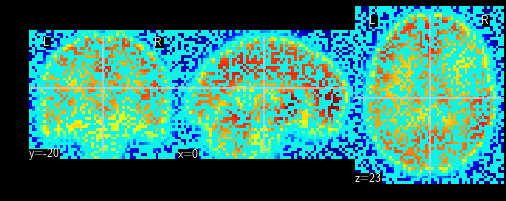

In [16]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

In [17]:
images_folder = "/work/scratch/tt1"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),image.index_img(x_miss_img,1), image.index_img(x_miss_img,1), "Rim Completion",
                                             observed_ratio, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt1/missing_ratio_60.00.png')
Called from mrd


In [18]:
ground_truth_tf = t3f.to_tt_tensor(ground_truth, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [19]:
A = t3f.get_variable('A', initializer=ground_truth_tf, trainable=False)

In [20]:
ground_truth = tf.get_variable('ground_truth', initializer=ground_truth, trainable=False)
sparsity_mask = tf.get_variable('sparsity_mask', initializer=mask_indices, trainable=False)
sparsity_mask = tf.cast(sparsity_mask,tf.float32)
sparse_observation = ground_truth * sparsity_mask

In [21]:
#sparsity_mask = t3f.get_variable('sparsity_mask', initializer=mask_indices_tf, trainable=False)
#sparsity_mask = t3f.cast(sparsity_mask, tf.float32)
#sparse_observation_tf = t3f.to_tt_tensor(sparse_observation, max_tt_rank=63)
#sparse_observation_tf3 = t3f.get_variable('sparse_observation_tf', initializer=sparse_observation_tf, trainable=False)

In [22]:
x_train_tf = t3f.to_tt_tensor(x_init, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [23]:
normAOmegavar = tf.get_variable('normAOmega', initializer=norm_sparse_observation, trainable=False)

In [24]:
X = t3f.get_variable('X', initializer=x_train_tf)

In [25]:
print X

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [26]:
def train_it_rel_cost(cost_hist, k):
    res = np.abs(cost_hist[k] - cost_hist[k-1])/np.abs(cost_hist[k])
    return res

In [27]:
counter = tf.get_variable('counter', initializer=0)

In [28]:
one = tf.constant(1)
zero_point1 = tf.constant(0.1)

In [29]:
tt_zeros = initializers.tensor_zeros([53, 63, 46, 144])

In [30]:
#eta_t3f_old = t3f.get_variable('eta_t3f_old', initializer=tt_zeros)
#grad_t3f_old = t3f.get_variable('grad_t3f_old', initializer=tt_zeros)

In [31]:
eta_old = tf.get_variable('eta_old', shape = (53, 63, 46, 144), validate_shape=False)
grad_old = tf.get_variable('grad_old', shape = (53, 63, 46, 144), validate_shape=False)

In [32]:
one = tf.constant(1)
zero_point1 = tf.constant(0.1)

In [33]:
# Algorithm
#grad_full = (t3f.full(X)*t3f.full(sparse_observation_tf3) - t3f.full(sparse_observation_tf3))
#counter_step = tf.assign(counter, counter + 1)

#grad_trans = t3f.riemannian.project(grad_t3f_old, X)
#eta_trans = t3f.riemannian.project(eta_t3f_old, X)
    
#grad_full = sparsity_mask * t3f.full(X) - sparse_observation
#grad_t3f = t3f.to_tt_tensor(grad_full, max_tt_rank=63)

#loss = 0.5 * t3f.frobenius_norm_squared(grad_t3f)
#gradnorm_omega = t3f.frobenius_norm(grad_t3f)/(normAOmegavar)

#riemannian_grad = t3f.riemannian.project(grad_t3f, X)


#eta_omega = sparsity_mask * t3f.full(-riemannian_grad)
#alpha = compute_step_size(eta_omega, grad_full)



#riemannian_grad_norm = t3f.flat_inner(riemannian_grad, riemannian_grad)



#rel_error1 = relative_error1(t3f.full(X), t3f.full(sparse_observation))




In [34]:
eps = 1e-5
epsilon_train=1e-5

In [35]:
#print grad_full

In [36]:
#print grad_t3f

In [37]:
print eps

1e-05


In [38]:
#alpha = 0.3


In [39]:
#sess = tf.Session()
#sess.run(tf.global_variables_initializer())

In [40]:
#first step

In [41]:
zero_point1 = tf.constant(0.1)
grad_full_0 = sparsity_mask * t3f.full(X) - sparse_observation
grad_t3f_0 = t3f.to_tt_tensor(grad_full_0, max_tt_rank=63)

gradnorm_omega_0 = t3f.frobenius_norm(grad_t3f_0)/(normAOmegavar)
riemannian_grad_0 = t3f.riemannian.project(grad_t3f_0, X)
riemannian_grad_0 = t3f.round(riemannian_grad_0, max_tt_rank =63, epsilon = 1e-15)

grad_t3f_old = t3f.get_variable('grad_t3f_old', initializer=riemannian_grad_0)

#grad_t3f_old_op = t3f.assign(grad_t3f_old, riemannian_grad_0, validate_shape=False)
riemannian_grad_full_0 = t3f.full(riemannian_grad_0)
riemannian_grad_init_op = tf.assign(grad_old,riemannian_grad_full_0)

eta_t3f_0 = -riemannian_grad_0
eta_t3f_old = t3f.get_variable('eta_t3f_old', initializer=eta_t3f_0)

eta_0 = -riemannian_grad_init_op
eta_omega_0 = sparsity_mask * t3f.full(-riemannian_grad_0)

alpha_0 = compute_step_size(eta_omega_0, riemannian_grad_init_op)
eta_op_0 = tf.assign(eta_old,eta_0, validate_shape=False)

train_step_0 = t3f.assign(X, t3f.round(X - alpha_0 * eta_t3f_0, max_tt_rank=63))



[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]


In [42]:
print "Rim 0:" + str(riemannian_grad_0)

Rim 0:A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [43]:
print "Eta 0: " + str(eta_t3f_0)

Eta 0: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [44]:
#tt = t3f.round(eta_t3f_old, max_tt_rank =63, epsilon = 1e-15

In [45]:
# new
#t3f.assign(eta_t3f_old, t3f.round(eta_t3f_old, max_tt_rank =63, epsilon = 1e-15))


In [46]:
counter_step = tf.assign(counter, counter + 1)

grad_trans = t3f.riemannian.project(grad_t3f_old, X)
eta_trans = t3f.riemannian.project(eta_t3f_old, X)
    
grad_full = sparsity_mask * t3f.full(X) - sparse_observation
grad_t3f = t3f.to_tt_tensor(grad_full, max_tt_rank=63)

loss = 0.5 * t3f.frobenius_norm_squared(grad_t3f)
gradnorm_omega = t3f.frobenius_norm(grad_t3f)/(normAOmegavar)

riemannian_grad =  t3f.round(t3f.riemannian.project(grad_t3f, X),max_tt_rank =63)
#riemannian_grad = t3f.round(riemannian_grad, max_tt_rank =63, epsilon = 1e-15)

inner_product_rim_grad = t3f.flat_inner(riemannian_grad, riemannian_grad)
ip_xitrans_xi = t3f.flat_inner(grad_trans,riemannian_grad)
theta = ip_xitrans_xi / inner_product_rim_grad

def get_theta():
    return t3f.full(ip_xitrans_xi / inner_product_rim_grad)

def get_value_zero_point1():
    return zero_point1
    
def get_conj_dir():
    return t3f.full(approximate.add_n([-riemannian_grad, beta*eta_trans], max_tt_rank=63))

def get_rim_grad():
    return t3f.full(-riemannian_grad)

# compute beta
inner_product_rim_grad_old = t3f.flat_inner(grad_t3f_old, grad_t3f_old)
beta = tf.maximum(0.0, (inner_product_rim_grad - ip_xitrans_xi)/inner_product_rim_grad_old)
#eta = -riemannian_grad + beta*eta_trans

print "Rim Grad shape: " + str(riemannian_grad)
print "eta_trans: " + str(eta_trans)

eta1 = tf.cond((theta >= zero_point1), get_rim_grad, get_conj_dir)

#eta = tf.case([(tf.greater_equal(theta_full,zero_point1), get_rim_grad)], default=get_conj_dir, exclusive=True)
#eta = approximate.add_n([-riemannian_grad, beta*eta_trans], max_tt_rank=63)
#
eta = t3f.to_tt_tensor(eta1,max_tt_rank=63)

print "eta: " + str(eta)
print "eta1: " + str(eta1)
                                            
#(1, 106, 126, 126, 1)

eta_omega = sparsity_mask * t3f.full(eta)
alpha = compute_step_size(eta_omega, grad_full)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]
Rim Grad shape: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)
eta_trans: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 106, 126, 126, 1)
Max_TT rank63
[1, 53, 63, 63, 1]
[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
eta: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)
eta1: Tensor("cond/Merge:0", shape=(53, 63, 46, 144), dtype=float32)


In [47]:
#eta1 = tf.cond((theta > zero_point1), get_rim_grad, get_conj_dir)

In [48]:
print eta

A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [49]:
train_step = t3f.assign(X, t3f.round(X - alpha * eta, max_tt_rank=63))

Max_TT rank63
[1, 53, 63, 63, 1]


In [50]:
eta_update_op = t3f.assign(eta_t3f_old, eta,use_locking = True)

In [51]:
grad_update_op = t3f.assign(grad_t3f_old, riemannian_grad)

In [52]:
print alpha_0

Tensor("div_1:0", shape=(), dtype=float32)


In [53]:
print theta

Tensor("div_3:0", shape=(), dtype=float32)


In [54]:
print zero_point1

Tensor("Const_7:0", shape=(), dtype=float32)


In [55]:
#t3f.round(-riemannian_grad + beta*eta_trans, max_tt_rank=[eta_trans])

In [56]:
#eta_update_op = t3f.assign(eta_t3f_old, eta,validate_shape=False, use_locking = True)

In [57]:
#grad_update_op = t3f.assign(grad_t3f_old, riemannian_grad)

In [58]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [59]:
log = []
train_loss_hist = []
#for i in range(1000):
gradnorm_val, alpha_val, eta_op_0_val,_ = sess.run([gradnorm_omega_0, alpha_0, eta_op_0, train_step_0.op])
print gradnorm_val, alpha_val

0.24615465 -1.0


In [60]:
print grad_trans

A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 106, 126, 126, 1)


In [61]:
#sess.run([loss])

In [62]:
#sess.run([theta])

In [63]:
#print theta

In [64]:
#sess.run([eta_trans])

In [65]:
#sess.run([eta])

In [66]:
#sess.run([train_step.op])

In [67]:
#sess.run([loss, gradnorm_omega, alpha, theta, eta_update_op, grad_update_op, train_step.op])

In [68]:


i = 0
#while gradnorm_val > eps:   
for k in range(20):
    i = i + 1
    F_v, gradnorm_val, alpha_val,theta_val, beta_val, _, _,_ = sess.run([loss, gradnorm_omega, alpha, theta, beta, train_step.op, eta_update_op.op, grad_update_op.op])
    #eta_old_val, grad_update_val,_ = sess.run([eta_update_op, grad_update_op])
    
    train_loss_hist.append(gradnorm_val)
    if i > 1:
        diff_train = np.abs(train_loss_hist[i - 1] - train_loss_hist[i-2])/np.abs(train_loss_hist[i-1])
        print (F_v, i, gradnorm_val, diff_train, alpha_val, theta_val, beta_val)
        if diff_train <= epsilon_train:
            print "Breaking after " + str(i) + " iterations"
            break
    else:
        print (F_v, i, gradnorm_val, alpha_val, theta_val, beta_val)
    log.append(F_v)

(24663590000000.0, 1, 0.1481859, -2.505052, 1.6633267, 0.0)
(1311180000000.0, 2, 0.034167238, 3.3370757, -2.3709517, -0.016963124, 0.05291626)
(250272380000.0, 3, 0.014927435, 1.2888887, -2.4217777, 0.09799764, 0.14790972)
(59810746000.0, 4, 0.007297403, 1.0455817, -2.5109663, 0.14728445, 0.16357599)
(25221583000.0, 5, 0.004738762, 0.53993875, -2.1024203, 0.024442906, 0.3080513)
(16543978000.0, 6, 0.0038379447, 0.23471348, -2.5946255, 0.2019907, 0.46734947)
(9721966000.0, 7, 0.0029420888, 0.3044966, -1.8757564, 0.026894508, 0.48466864)
(7305706000.0, 8, 0.002550409, 0.1535753, -2.649425, 0.20855515, 0.53354335)
(5484598000.0, 9, 0.0022097907, 0.15414047, -1.7026604, -0.07656844, 0.71969944)
(4659999000.0, 10, 0.002036909, 0.0848745, -2.6293497, 0.260724, 0.59864646)
(3872055000.0, 11, 0.0018567331, 0.09703925, -1.4807296, -0.13450162, 0.88041246)
(3468746000.0, 12, 0.0017573772, 0.05653649, -2.590522, 0.32395697, 0.59710145)
(3070246400.0, 13, 0.001653352, 0.06291771, -1.4138776, -0.23

In [93]:
print beta

Tensor("Maximum:0", shape=(), dtype=float32)


In [94]:
#sess.run([eta_update_op.op, grad_update_op.op])

In [95]:
print X

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [96]:
estimated_val = sess.run(t3f.full(X))

In [97]:
ground_truth_val = sess.run(ground_truth)


In [98]:
x_reconstr = mt.reconstruct(estimated_val,ground_truth_val, ten_ones, mask_indices)


In [99]:
def relative_error(x_hat,x_true):
    percent_error = np.linalg.norm(x_hat - x_true) / np.linalg.norm(x_true)
    return percent_error

In [100]:
rel_error = relative_error(estimated_val,ground_truth_val)

In [101]:
print rel_error

0.003592692


In [102]:
rel_error_rec = relative_error(x_reconstr,ground_truth_val)

In [103]:
rel_error_rec

0.0028439665588006063

In [104]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [105]:
x_miss = image.index_img(x_miss_img,1)

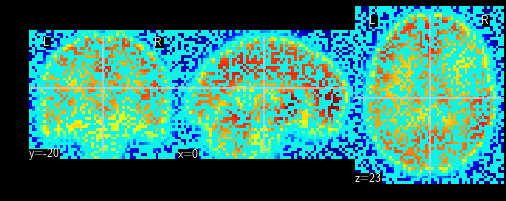

In [106]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

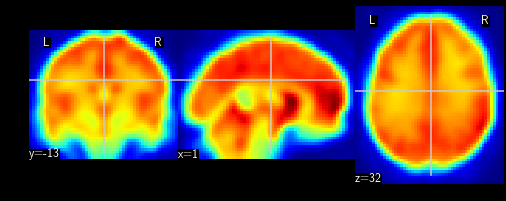

In [107]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, x_reconstr)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

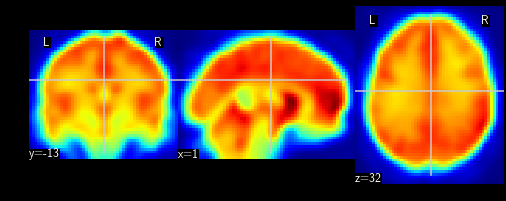

In [108]:
x_true_org_img = image.index_img(x_true_org,1)
org_image = plotting.plot_epi(x_true_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [109]:
images_folder = "/work/scratch/tt1/1"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),x_hat, image.index_img(x_miss_img,1), "Rim Completion",
                                             rel_error_rec, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt1/1/missing_ratio_60.00.png')
Called from mrd


In [110]:
estimated_val_img = mt.reconstruct_image_affine(x_true_org, estimated_val)

In [111]:
estimated_val_hat = image.index_img(estimated_val_img,1)

In [112]:
images_folder = "/work/scratch/tt1/2"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),estimated_val_hat,image.index_img(x_miss_img,1), "Rim Completion2",
                                             rel_error_rec, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt1/2/missing_ratio_60.00.png')
Called from mrd


In [113]:
def tsc(x_hat,x_true, ten_ones, mask):
    nomin = np.linalg.norm(np.multiply((ten_ones - mask), (x_true - x_hat)))
    denom = np.linalg.norm(np.multiply((ten_ones - mask), x_true))
    score = nomin/denom
    return score  

In [114]:
tsc_score = tsc(estimated_val,ground_truth_val, ten_ones, mask_indices)

In [115]:
tsc_score

0.0036712716544984487